# Data exploration from drive
After we have trained the car, we need to load the data saved to the notebook.

## Importing data recorded from simulator

In [1]:
import pandas as pd
import numpy as np

# Open the training "datafile" 
df = pd.read_csv('./my_data/driving_log.csv', header=None,
                 names=['center_img', 'left_img', 'right_img', 'steering','throttle','brake','speed'])

print("Number of frames saved (center):", df.size)

# Show the first lines of the CSV file
df.head()

Number of frames saved (center): 24157


,center_img,left_img,right_img,steering,throttle,brake,speed
0,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,-0.085714,0.0,0,29.27872
1,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,-0.085714,0.0,0,29.04254
2,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,-0.075000,0.0,0,28.80865
3,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,-0.050000,0.0,0,28.63523
4,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,/media/puma/bigdisk/udacity/carnd/CarND-Behavi...,0.010714,0.0,0,28.40466


Let's pick some images saved during the training drive


In [2]:
### Import file names
center_my_frame_path = df['center_img']
left_my_frame_path = df['left_img']
right_my_frame_path = df['right_img']

steering = df['steering'].astype(np.float32)


# Load image and 
import cv2
def load_image_and_append(img_path_list):
    img_list = []
    for img_path in img_path_list:
        img_bgr = cv2.imread(img_path)
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_list.append(img)
    return img_list
    
center_my_frames = load_image_and_append(center_my_frame_path)
left_my_frames = load_image_and_append(left_my_frame_path)
right_my_frames = load_image_and_append(right_my_frame_path)



Images left vector dimension: 3451
Images center vector dimension: 3451
Images right vector dimension: 3451


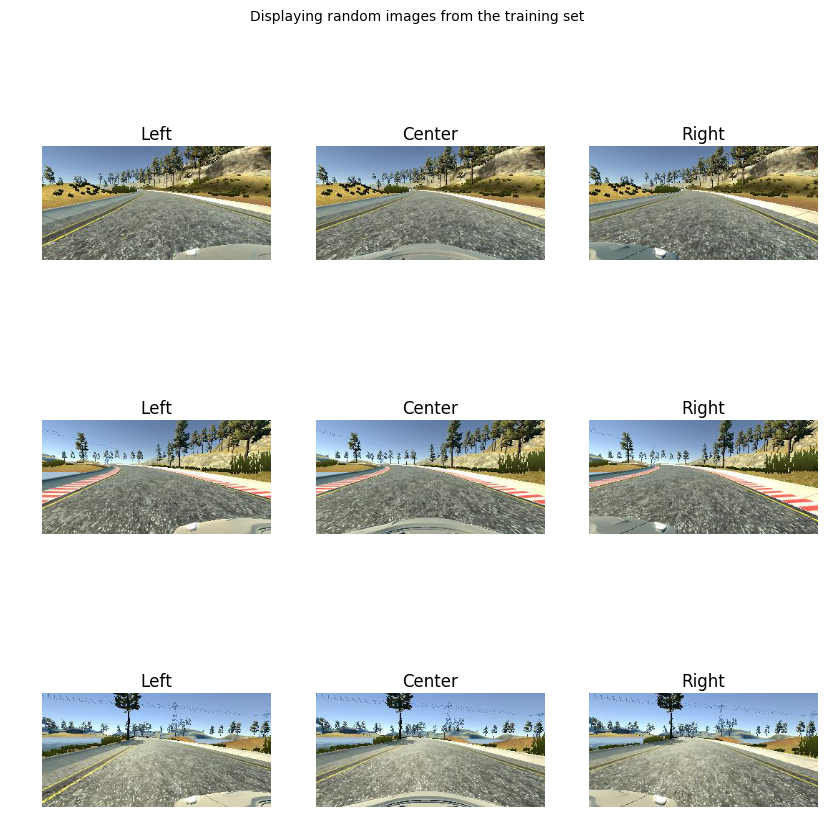

In [3]:
print('Images left vector dimension:', len(left_my_frames) )
print('Images center vector dimension:', len(center_my_frames) )
print('Images right vector dimension:', len(right_my_frames) )

### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Displaying random images from the training set
plt.figure(figsize=(10,10))
plot_number = 0
number_subplots = 3

for plot_number in range(number_subplots):
    plt.subplot(number_subplots, 3, plot_number*3+1)
    image = left_my_frames[plot_number*100]
    plt.axis('off')
    plt.title('Left')
    plt.imshow(image)
    
    plt.subplot(number_subplots, 3, plot_number*3+2)
    image = center_my_frames[plot_number*100]
    plt.axis('off')
    plt.title('Center')
    plt.imshow(image)
    
    plt.subplot(number_subplots, 3, plot_number*3+3)
    image = right_my_frames[plot_number*100]
    plt.title('Right')
    plt.axis('off')
    plt.imshow(image)
    
plt.suptitle('Displaying random images from the training set')
plt.show()


### What is the distribution of the steering data

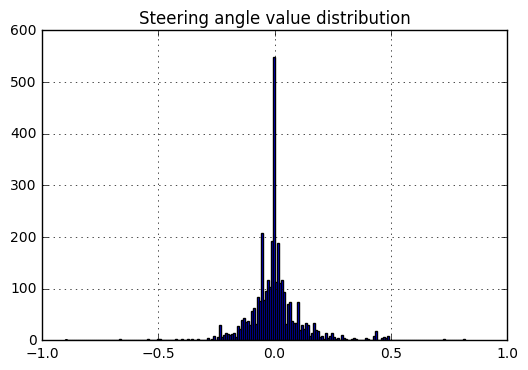

Mean 0.0024547725915908813


In [4]:
# Histogram for steering angle value distribution whole training set
bins = 50*4
plt.hist(steering, bins, color='blue'  )
plt.grid('on')
plt.title('Steering angle value distribution')
plt.show()
print('Mean', np.mean(steering))

In [5]:
# Cutoff steering angle value to drop some images where the vehicle drives straights
cutoff = 0.001


indices_zero_steer = steering[np.abs(steering)<cutoff].index

print('Number of images under cutoff:', steering[indices_zero_steer].shape)
print('Percentage of images under cutoff:', steering[indices_zero_steer].shape[0]/steering.shape[0])

indices_zero_steer_delete = indices_zero_steer[(np.int32(indices_zero_steer)%2)==0]

print('Size of number of steering images to drop (even indices):', indices_zero_steer_delete.shape)

Number of images under cutoff: (502,)
Percentage of images under cutoff: 0.14546508258475804
Size of number of steering images to drop (even indices): (252,)


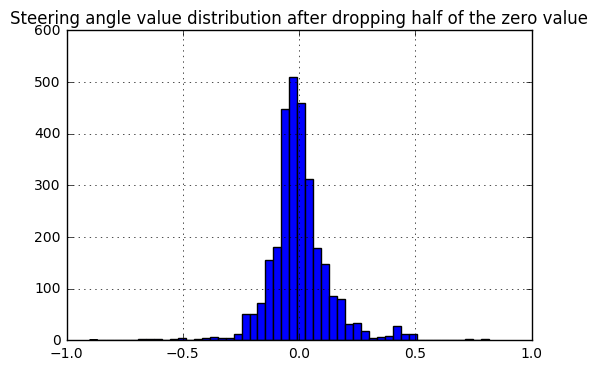

Mean 0.0028726416639983654


In [6]:
# Removing half of the steering values
bins = 50
plt.hist(steering.drop(indices_zero_steer), bins, color='blue')
plt.grid('on')
plt.title('Steering angle value distribution after dropping half of the zero value')
plt.show()

print('Mean', np.mean(steering.drop(indices_zero_steer)))

In [7]:
for i in sorted(indices_zero_steer, reverse=True):
    del center_my_frames[i]
    
X_train_list = center_my_frames
y_train_list = steering.drop(indices_zero_steer).astype(np.float32)

In [8]:
print(len(X_train_list))
print(len(y_train_list))

2949
2949


## Adding left and right video stream

In [9]:
print('Training size with just center video stream:', len(X_train_list))
print('Training size of the angles:', len(y_train_list))
# Add left
for i in sorted(indices_zero_steer, reverse=True):
    del left_my_frames[i]
X_train_list.extend(left_my_frames)
y_train_list = y_train_list.append(steering.drop(indices_zero_steer) + 0.2 ).astype(np.float32)

print('Training size with left video stream:', len(X_train_list))
print('Training size of the angles:', len(y_train_list))

# Add right
for i in sorted(indices_zero_steer, reverse=True):
    del right_my_frames[i]
X_train_list.extend(right_my_frames)
y_train_list = y_train_list.append(steering.drop(indices_zero_steer) - 0.2).astype(np.float32)

print('Total training size with left, center and right video stream:', len(X_train_list))
print('Training size of the angles:', len(y_train_list))

Training size with just center video stream: 2949
Training size of the angles: 2949
Training size with left video stream: 5898
Training size of the angles: 5898
Total training size with left, center and right video stream: 8847
Training size of the angles: 8847


In [10]:
# Clear temp variable
del left_my_frames
del right_my_frames
del center_my_frames

In [11]:
# Construct tensor from list
X_train = np.array(X_train_list)
del X_train_list
y_train = np.array(y_train_list)
del y_train_list

# Construct Neural Net Architecture

In [45]:
# TODO: Build a model
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import Input
from keras.activations import relu, softmax
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.engine.topology import Merge, merge

model_input = Input(shape=(160, 320, 3))
model_stem = model_input
model_stem = Lambda(lambda x: (x-128.0)/255.0, input_shape=model_stem.get_shape()[1:]) (model_stem)
model_stem = Cropping2D(cropping=((60,20),(0,0)), input_shape=model_stem.get_shape()[1:]) (model_stem)
model_stem = Convolution2D(32, 3, 3, border_mode='valid', subsample=(2, 2))(model_stem)
model_stem = MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='same') (model_stem)
branch_input = Activation('elu')(model_stem)

left_branch = Convolution2D(32, 1 , 1,border_mode='same')(branch_input)

right_branch = Convolution2D(32, 7, 1, border_mode='same')  (branch_input)
right_branch = BatchNormalization(epsilon=0.001, mode=0, axis=3, momentum=0.9) (right_branch)
right_branch = Activation('elu') (right_branch)
right_branch = Convolution2D(32, 1, 7, border_mode='same') (right_branch)
right_branch = BatchNormalization(epsilon=0.001, mode=0, axis=3, momentum=0.9) (right_branch)
right_branch = Activation('elu') (right_branch)

merged = merge([left_branch, right_branch], mode='sum') 

merged = Convolution2D(64, 3, 3, border_mode='valid', activation='elu', subsample=(2, 2))(merged)
merged = BatchNormalization(epsilon=0.001, mode=0, axis=-1, momentum=0.9)(merged)
merged = Convolution2D(64, 3, 3, border_mode='valid', activation='elu',  subsample=(2, 2))(merged)
merged = Flatten()(merged)
merged = Dropout(0.5)(merged)
merged = Dense(128, activation='elu')(merged)
merged = Dense(43)(merged)
merged = Dense(1)(merged)


# Compile and train the model
model =  Model(input=model_input, output=merged) 
model.compile(loss='mean_squared_error', optimizer='adam')


In [46]:
# Display the model
print(model.summary())

from keras.utils.visualize_util import plot
plot(model, to_file='model.png', show_shapes=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 160, 320, 3)   0                                            
____________________________________________________________________________________________________
lambda_9 (Lambda)                (None, 160, 320, 3)   0           input_9[0][0]                    
____________________________________________________________________________________________________
cropping2d_7 (Cropping2D)        (None, 80, 320, 3)    0           lambda_9[0][0]                   
____________________________________________________________________________________________________
convolution2d_49 (Convolution2D) (None, 39, 159, 32)   896         cropping2d_7[0][0]               
___________________________________________________________________________________________

<img src="model.png" alt="Model"/>

In [47]:
# Shuffle the data before performing validation split
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

# Train the model
# History is a record of training loss and metrics
history = model.fit(X_train, y_train, batch_size=256, nb_epoch=2, validation_split=0.1, shuffle=True)



Train on 7962 samples, validate on 885 samples
Epoch 1/5
7962/7962 [==============================] - 8s - loss: 3.9982 - val_loss: 0.1415
Epoch 2/5
7962/7962 [==============================] - 6s - loss: 0.1017 - val_loss: 0.0262
Epoch 3/5
7962/7962 [==============================] - 6s - loss: 0.0441 - val_loss: 0.0217
Epoch 4/5
7962/7962 [==============================] - 6s - loss: 0.0327 - val_loss: 0.0190
Epoch 5/5
7962/7962 [==============================] - 6s - loss: 0.0272 - val_loss: 0.0172


In [49]:
# Calculate test score
test_score = model.evaluate(X_train, y_train)
print(test_score)

import os
os.remove("model.h5")
model.save("model.h5")

8832/8847 [============================>.] - ETA: 0s0.0171296943981


TypeError: ('Not JSON Serializable:', Dimension(160))